In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tensorflow.keras.preprocessing.text import Tokenizer
import time
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('pytorch using ', device.type)

pytorch using  cuda


In [3]:
# hyperparameter

max_words = 10000
sentence_len = 20
pred_len = 1
train_len = sentence_len - pred_len

epochs = 10
batch_size = 2**10

max_samples = int(5e6)


## Data retrieval

In [4]:
with open('processed_texts.csv', 'r', encoding='UTF-8') as file:
    train_data = [line.strip('\n') for line in file]

# tokenize words in text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)

# sentences as word sequences with max_words or words in text if less
sequences = tokenizer.texts_to_sequences(train_data)

# save tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Flatten the list of lists to apply sliding window
text = [item for sublist in sequences for item in sublist]

# Reverse dictionary to decode tokenized sequences back to words
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

vocabulary = set([reverse_word_map[tk] for tk in text])
vocab_size = len(vocabulary)
print("vocab size:", vocab_size)

vocab size: 9999


In [5]:

# Sliding window to generate train data
seq = []
for i in range(len(text)-sentence_len):
    seq.append(text[i:i+sentence_len])

# reduce length of seq for performance reasons and of cause test_set
print('available samples: ', len(seq))
seq = seq[:max_samples]

# set data, label
X = []
y = []
for i in seq:
    X.append(i[:train_len])
    y.append(i[-1])

num_samples = len(y)

X = np.array(X)
y = np.array(y)

print('training samples: ', num_samples)

available samples:  4925514
training samples:  4925514


In [21]:

# split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2)

# setting type for device
X_type = torch.cuda.LongTensor if device.type == 'cuda' else torch.LongTensor
y_type = torch.cuda.LongTensor if device.type == 'cuda' else torch.LongTensor

# create feature and targets tensor for train set.
torch_X_train = torch.from_numpy(X_train).type(X_type)
torch_y_train = torch.from_numpy(y_train).type(y_type)

# create feature and targets tensor for valid set.
torch_X_valid = torch.from_numpy(X_valid).type(X_type)
torch_y_valid = torch.from_numpy(y_valid).type(y_type)

# Pytorch train and valid sets
train = torch.utils.data.TensorDataset(torch_X_train, torch_y_train)
valid = torch.utils.data.TensorDataset(torch_X_valid, torch_y_valid)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True)


print('batches: ', len(valid_loader))

batches:  1


## Model functions

In [1]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    correct = 0
    losses = 0
    num_batches = len(data_loader) 
    
    for X_batch, y_batch in data_loader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        
        loss.backward()
        optimizer.zero_grad()
        optimizer.step()

        losses += loss.item()
        predicted = torch.max(pred.data, 1)[1]  # maxout
        correct += (predicted == y_batch).sum()
    
    # average loss and accuracies per epoch
    loss = losses / float(num_batches)
    accu = correct / float(batch_size * num_batches)
    
    return loss, accu.cpu()


def test(model, criterion, data_loader):
    model.eval()
    correct = 0
    losses = 0
    num_batches = len(data_loader) 

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(X_batch)
            loss = criterion(pred, y_batch)

            losses += loss.item()
            predicted = torch.max(pred.data, 1)[1]  # maxout
            correct += (predicted == y_batch).sum()
    
    # average loss and accuracies per epoch
    loss = losses  / float(num_batches)
    accu = correct / float(batch_size * num_batches)
    
    return loss, accu.cpu()


def fit(model, train_loader, valid_loader, optimizer, criterion, scheduler=None, save_model=False):
    print("fitting model...")
    
    train_eval = []
    valid_eval = []
    fit_start = time.time()

    #iteration 0 (only testing initial model)
    train_loss, train_accu = test(model, criterion, train_loader)
    train_eval.append( (train_loss, train_accu) )
    valid_loss, valid_accu = test(model, criterion, valid_loader)
    valid_eval.append( (valid_loss, valid_accu) )
    print('Epoch: 0')
    print('Train:        Loss: {:.6f}   Accuracy: {:.2f}%  '.format(train_loss, train_accu * 100))
    print('Validation:   Loss: {:.6f}   Accuracy: {:.2f}%\n'.format(valid_loss , valid_accu * 100))

    for epoch in range(epochs):
        epoch_start = time.time()

        train_loss, train_accu = train(model, criterion, optimizer, train_loader)
        train_eval.append( (train_loss, train_accu) )
        
        valid_loss, valid_accu = test(model, criterion, valid_loader)
        valid_eval.append( (valid_loss, valid_accu) )

        if(scheduler != None): scheduler.step()  # update learning rate

        print('Epoch: {},    duration: {:.2f}sec'.format(epoch + 1, time.time() - epoch_start))
        print('Train:        Loss: {:.6f}   Accuracy: {:.2f}%  '.format(train_loss, train_accu * 100))
        print('Validation:   Loss: {:.6f}   Accuracy: {:.2f}%\n'.format(valid_loss , valid_accu * 100))

    d = time.gmtime(time.time() - fit_start)
    print('duration of fitting: {:2d}h {:2d}min {:2d}sec'.format(d.tm_hour, d.tm_min, d.tm_sec))

    # save model
    if save_model:
        dt_str = ''.join(['_'+str(t) for t in time.localtime(time.time())[:4]])
        path = './models/' + model.__class__.__name__ + dt_str + '.pth'
        torch.save(model, path)

    return np.array(train_eval), np.array(valid_eval)


def plot_eval(train_eval, valid_eval):

    train_losses = train_eval[:, 0]
    train_accus  = train_eval[:, 1]
    valid_losses = valid_eval[:, 0]
    valid_accus  = valid_eval[:, 1]
    min_loss_idx = np.argmin(valid_losses)
    max_accu_idx = np.argmax(valid_accus)

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(train_losses, label="train")
    plt.plot(valid_losses, label="validation")
    plt.scatter(min_loss_idx, valid_losses[min_loss_idx], c='r', label="minimum")
    plt.title("evaluation of losses")
    plt.xlabel("epochs")
    plt.legend()
    plt.subplot(122)
    plt.plot(train_accus, label="train")
    plt.plot(valid_accus, label="validation")
    plt.scatter(max_accu_idx, valid_accus[max_accu_idx], c='r', label="maximum")
    plt.title("evaluation of accuracy")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()


def save_eval_data(model, train_eval, valid_eval):
    data = np.array([train_eval, valid_eval])
    path = './models/evalutation_' + model.__class__.__name__
    numpy.savetxt(path, data, delimiter=",")

## load pretrained embedding-layer

In [40]:
import bcolz
import os

glove_path = './'
vectors = bcolz.open(f'{glove_path}/6B.50.dat')[:]
words = pickle.load(open(f'{glove_path}/6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}


matrix_len = vocab_size + 1
emb_dim = 50
weights_matrix = np.zeros((matrix_len, emb_dim))
words_found = 0
unknown_words = []

for i, word in enumerate(vocabulary):
    try: 
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))
        unknown_words.append(word)
        
print(f'{vocab_size - words_found} unknown words where added as random vector')

num_embeddings, embedding_dim = weights_matrix.shape
emb_layer = nn.Embedding(num_embeddings, embedding_dim)
emb_layer.load_state_dict({ 'weight': torch.tensor(weights_matrix) })
emb_layer.weight.requires_grad = False  # non trainable if False
emb_layer

145 unknown words where added as random vector


Embedding(10000, 50)

In [50]:
# print(np.array(unknown_words[:]))
# print(glove['bike'])
exp = np.zeros((num_embeddings))
exp[12] = 1
exp = torch.from_numpy(exp).type(torch.LongTensor)
res = emb_layer(exp).numpy()
print(res.shape)

(10000, 50)


## Models

In [26]:
learning_rate = 0.02
m1_embedding_dim=50
m1_lstm_hidden = 100
m1_dense_features = 100
m1_dropout = 0.3

class Model1(nn.Module):
    
    def __init__(self):
        super(Model1, self).__init__()
        self.embed = nn.Embedding(  num_embeddings=vocab_size + 1, 
                                    embedding_dim=m1_embedding_dim, 
                                    padding_idx=train_len)
        self.rnn = nn.LSTM(input_size=m1_embedding_dim, 
                            hidden_size=m1_lstm_hidden, 
                            num_layers=2)
        self.dense1 = nn.Linear(in_features=m1_lstm_hidden, 
                                out_features=m1_dense_features)
        self.dense2 = nn.Linear(in_features=m1_dense_features, 
                                out_features=vocab_size)
    
    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)  # _ = (h, c)
        x = x[:,-1,:]  
        x = F.relu( self.dense1(x) )
        x = F.dropout(x, p=m1_dropout)
        x = self.dense2(x)
        # x = F.log_softmax(x)  # this step is part of CrossEntropyLoss
        return x


model1 = Model1().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)

model1

Model1(
  (embed): Embedding(10000, 50, padding_idx=19)
  (rnn): LSTM(50, 100, num_layers=2)
  (dense1): Linear(in_features=100, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=9999, bias=True)
)

In [27]:
learning_rate = 0.02
m2_embedding_dim=50
m2_gru_hidden = 100
m2_dense_features = 100
m2_dropout = 0.3

class Model2(nn.Module):
    
    def __init__(self):
        super(Model2, self).__init__()
        self.embed = nn.Embedding(  num_embeddings=vocab_size + 1, 
                                    embedding_dim=m2_embedding_dim, 
                                    padding_idx=train_len)
        self.rnn = nn.GRU(input_size=m1_embedding_dim, 
                            hidden_size=m2_gru_hidden, 
                            num_layers=3)
        self.dense1 = nn.Linear(in_features=m2_gru_hidden, 
                                out_features=m2_dense_features)
        self.dense2 = nn.Linear(in_features=m2_dense_features, 
                                out_features=vocab_size)
    
    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)  # _ = (h, c)
        x = x[:,-1,:]
        x = F.relu( self.dense1(x) )
        x = F.dropout(x, p=m1_dropout)
        x = self.dense2(x)
        # x = F.log_softmax(x)  # this step is part of CrossEntropyLoss
        return x


model2 = Model2().to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)

model2

Model2(
  (embed): Embedding(10000, 50, padding_idx=19)
  (rnn): GRU(50, 100, num_layers=3)
  (dense1): Linear(in_features=100, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=9999, bias=True)
)

In [28]:
learning_rate = 0.06
m3_embedding_dim=50
m3_lstm_hidden = 40
m3_lstm_dropout = 0.1
m3_dense_features = 100
m3_dropout = 0.3

class Model3(nn.Module):
    
    def __init__(self):
        super(Model3, self).__init__()
        self.embed = nn.Embedding(  num_embeddings=vocab_size + 1, 
                                    embedding_dim=m3_embedding_dim, 
                                    padding_idx=train_len)
        self.rnn = nn.LSTM(input_size=m3_embedding_dim, 
                            hidden_size=m3_lstm_hidden, 
                            num_layers=3,
                            dropout=m3_lstm_dropout)
        self.dense1 = nn.Linear(in_features=m3_lstm_hidden, 
                                out_features=m3_dense_features)
        self.dense2 = nn.Linear(in_features=m3_dense_features, 
                                out_features=vocab_size)
    
    def forward(self, x):
        x = self.embed(x)
        x, _ = self.rnn(x)  # _ = (h, c)
        x = x[:,-1,:]
        x = F.relu( self.dense1(x) )
        x = F.dropout(x, p=m1_dropout)
        x = self.dense2(x)
        # x = F.log_softmax(x)  # this step is part of CrossEntropyLoss
        return x


model3 = Model3().to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
scheduler3 = None  # optim.lr_scheduler.MultiplicativeLR(optimizer3, lambda epoch: 0.95)

model3

Model3(
  (embed): Embedding(10000, 50, padding_idx=19)
  (rnn): LSTM(50, 40, num_layers=3, dropout=0.1)
  (dense1): Linear(in_features=40, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=9999, bias=True)
)

## fitting & evaluation

In [29]:
criterion = nn.CrossEntropyLoss().to(device) 

fitting model...
Epoch: 0
Train:        Loss: 9.213288   Accuracy: 0.00%  
Validation:   Loss: 9.209864   Accuracy: 0.00%

Epoch: 1,    duration: 0.10sec
Train:        Loss: 9.211847   Accuracy: 0.00%  
Validation:   Loss: 9.210328   Accuracy: 0.00%

Epoch: 2,    duration: 0.05sec
Train:        Loss: 9.212205   Accuracy: 0.00%  
Validation:   Loss: 9.209519   Accuracy: 0.00%

Epoch: 3,    duration: 0.05sec
Train:        Loss: 9.212994   Accuracy: 0.00%  
Validation:   Loss: 9.211212   Accuracy: 0.00%

Epoch: 4,    duration: 0.05sec
Train:        Loss: 9.211873   Accuracy: 0.00%  
Validation:   Loss: 9.211139   Accuracy: 0.00%

Epoch: 5,    duration: 0.05sec
Train:        Loss: 9.214406   Accuracy: 0.00%  
Validation:   Loss: 9.212485   Accuracy: 0.00%

Epoch: 6,    duration: 0.05sec
Train:        Loss: 9.213113   Accuracy: 0.00%  
Validation:   Loss: 9.213310   Accuracy: 0.00%

Epoch: 7,    duration: 0.05sec
Train:        Loss: 9.212792   Accuracy: 0.00%  
Validation:   Loss: 9.209712 

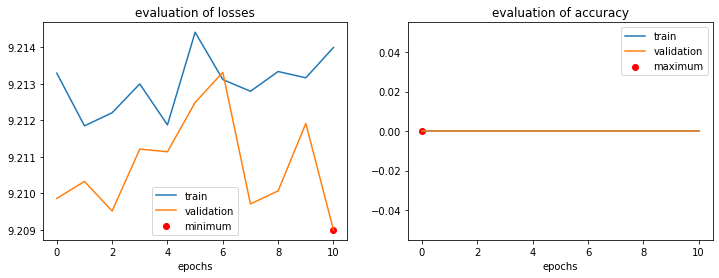

In [30]:
eval_train1, eval_valid1 = fit(model1, train_loader, valid_loader, optimizer1, criterion, save_model=False)
plot_eval(eval_train1, eval_valid1)

fitting model...
Epoch: 0
Train:        Loss: 9.206982   Accuracy: 0.00%  
Validation:   Loss: 9.220809   Accuracy: 0.00%

Epoch: 1,    duration: 0.06sec
Train:        Loss: 9.209461   Accuracy: 0.00%  
Validation:   Loss: 9.215740   Accuracy: 0.00%

Epoch: 2,    duration: 0.05sec
Train:        Loss: 9.209393   Accuracy: 0.10%  
Validation:   Loss: 9.218997   Accuracy: 0.00%

Epoch: 3,    duration: 0.05sec
Train:        Loss: 9.207517   Accuracy: 0.00%  
Validation:   Loss: 9.220004   Accuracy: 0.00%

Epoch: 4,    duration: 0.05sec
Train:        Loss: 9.210768   Accuracy: 0.00%  
Validation:   Loss: 9.219805   Accuracy: 0.00%

Epoch: 5,    duration: 0.05sec
Train:        Loss: 9.207583   Accuracy: 0.00%  
Validation:   Loss: 9.211176   Accuracy: 0.00%

Epoch: 6,    duration: 0.05sec
Train:        Loss: 9.207344   Accuracy: 0.00%  
Validation:   Loss: 9.218021   Accuracy: 0.00%

Epoch: 7,    duration: 0.05sec
Train:        Loss: 9.208278   Accuracy: 0.00%  
Validation:   Loss: 9.216516 

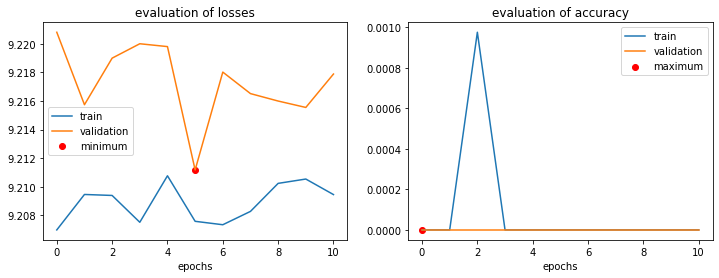

In [31]:
eval_train2, eval_valid2 = fit(model2, train_loader, valid_loader, optimizer2, criterion, save_model=False)
plot_eval(eval_train2, eval_valid2)

fitting model...
Epoch: 0
Train:        Loss: 9.212732   Accuracy: 0.10%  
Validation:   Loss: 9.205050   Accuracy: 0.00%

Epoch: 1,    duration: 0.09sec
Train:        Loss: 9.212479   Accuracy: 0.00%  
Validation:   Loss: 9.204548   Accuracy: 0.00%

Epoch: 2,    duration: 0.07sec
Train:        Loss: 9.210285   Accuracy: 0.00%  
Validation:   Loss: 9.207494   Accuracy: 0.00%

Epoch: 3,    duration: 0.07sec
Train:        Loss: 9.210322   Accuracy: 0.00%  
Validation:   Loss: 9.198421   Accuracy: 0.00%

Epoch: 4,    duration: 0.07sec
Train:        Loss: 9.213025   Accuracy: 0.00%  
Validation:   Loss: 9.202411   Accuracy: 0.00%

Epoch: 5,    duration: 0.07sec
Train:        Loss: 9.210827   Accuracy: 0.00%  
Validation:   Loss: 9.205703   Accuracy: 0.00%

Epoch: 6,    duration: 0.07sec
Train:        Loss: 9.211947   Accuracy: 0.00%  
Validation:   Loss: 9.210625   Accuracy: 0.00%

Epoch: 7,    duration: 0.07sec
Train:        Loss: 9.210050   Accuracy: 0.00%  
Validation:   Loss: 9.201685 

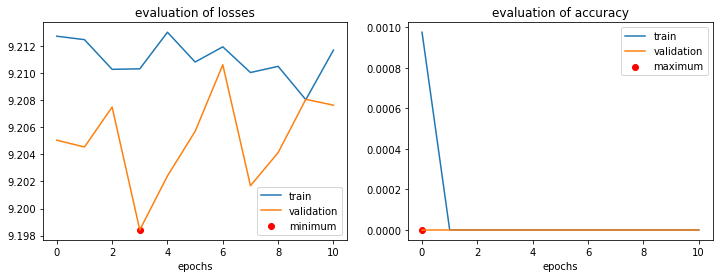

In [32]:
eval_train3, eval_valid3 = fit(model3, train_loader, valid_loader, optimizer3, criterion, scheduler3, save_model=False)
plot_eval(eval_train3, eval_valid3)

## Generating sentences

In [35]:
def gen(model, sentence, iterations=10):

    sequences = tokenizer.texts_to_sequences([sentence])
    seq = [item for sublist in sequences for item in sublist] # tokenized words
    #if(len(seq) < train_len): return -1
    
    for i in range(iterations):
        iput = np.array(seq[-19:])
        iput = np.vstack(iput).T
        iput = torch.from_numpy(iput).type(X_type)

        # oput = F.log_softmax( model(iput) )  # prob dist
        oput = model(iput)
        
        oput = oput.cpu().detach().numpy()[0]
        # print(np.average(oput))
        oput = np.argmax(oput) # one-hot to long
        seq.append(oput)

    pred_sen = ''
    for tk in seq:
        pred_sen += reverse_word_map[tk] + ' '
    return pred_sen


In [37]:
sen = "Calls on Member States, in the light of the growing risks which the European Union is running in terms of energy security"
sen = "in the light of the growing risks"
print(gen(model1, sen))
print(gen(model3, sen))

in the light of the growing risks albert islands buttons crushed buttons smartphone worldview name dr takes 
in the light of the growing risks allowing unable acting greek clitoris unable nursing ladies disappear blame 
